In [1]:
import os
import sys
import gc
import json
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from typing import List, NoReturn, Union, Tuple, Optional, Set, Dict, Any

import lightgbm as lgb
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm
tqdm.pandas()

from load_data import load_train_valid_data, load_live_data
from transformer import (
    EraLoader,
 #   Transformer,
)

import logging
logging.getLogger("lightning").setLevel(logging.ERROR)

logger = logging.getLogger(__name__)

# torch.set_float32_matmul_precision('medium') # default: 'low'

# fix random seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# python version
print('python version: %s' % (sys.version))

python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]


In [2]:

# os.environ['KMP_DUPLICATE_LIB_OK']='True'
train, valid = load_train_valid_data("full")
train_eras = (
    train["era_int"].unique().tolist()
    + valid["era_int"].unique()[: int(len(valid["era"].unique()) * 0.4)].tolist()
)

validation_eras = valid["era_int"].unique().tolist()[
    int(len(valid["era"].unique()) * 0.6) :
]

feature_names = [f for f in train.columns if "feature_" in f]
target_names = [f for f in train.columns if "target_" in f]
PRIMARY_TARGET = "target_cyrus_v4_20"

with open("../data/features.json") as f:
    features_meta = json.load(f)
medium_feature_set = features_meta["feature_sets"]["medium"]
medium_feature_set_index = [feature_names.index(f) for f in medium_feature_set]

e:\numerai_research\v4_2_rain\src\load_data.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df["era_int"] = train_df["era"].astype(int)
e:\numerai_research\v4_2_rain\src\load_data.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_df["era_int"] = valid_df["era"].astype(int)


In [3]:
def train_model_farm(
    df_train: pd.DataFrame, feature_names: List[str], target_names: List[str]
) -> Dict:
    models = {}

    models["model_1"] = Ridge(alpha=1.0, fit_intercept=True, random_state=42)
    models["model_2"] = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        n_jobs=-1,
    )
    models["model_3"] = lgb.LGBMRegressor(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=3,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
    )
    models["model_4"] = lgb.LGBMRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=3,
        colsample_bytree=0.5,
        random_state=42,
        n_jobs=-1,
    )

    for model_name, model in models.items():
        print(f"Training {model_name}")
        model.fit(df_train[feature_names], df_train[target_names])
        print(f"Finished training {model_name}")

    return models


def make_model_farm_predictions(models, df, feature_names):
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = model.predict(df[feature_names])


    # add random predictions
    predictions["model_99"] = np.random.normal(
        0, 1, size=len(df)
    )  # random predictions
    return predictions


def unif(df):
    """from example scripts"""
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

In [4]:
if os.path.exists("trained_models_farm.pkl"):
    trained_models = pd.read_pickle("trained_models_farm.pkl")
else:
    trained_models = train_model_farm(
        train, medium_feature_set, target_names=PRIMARY_TARGET
    )
    # save models
    pd.to_pickle(trained_models, "trained_models_farm.pkl")

train_predictions = make_model_farm_predictions(
    trained_models, train, medium_feature_set
)
valid_predictions = make_model_farm_predictions(
    trained_models, valid, medium_feature_set
)

Training model_1
Finished training model_1
Training model_2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.355029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 2420521, number of used features: 583
[LightGBM] [Info] Start training from score 0.500015
Finished training model_2
Training model_3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.568971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2915
[LightGBM] [Info] Number of data points in the train set: 2420521, number of used features: 583
[LightGBM] [Info] Start training from score 0.500015
Finished training model_3
Training model_4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.040255 secon

In [5]:
train_predictions_df = pd.DataFrame(train_predictions).add_prefix("predictions_")
valid_predictions_df = pd.DataFrame(valid_predictions).add_prefix("predictions_")

In [6]:
train_predictions_df["era"] = train["era"].values
valid_predictions_df["era"] = valid["era"].values

train_predictions_df["era_int"] = train["era_int"].values
valid_predictions_df["era_int"] = valid["era_int"].values

train_predictions_df["id"] = train.index.values
valid_predictions_df["id"] = valid.index.values

train_predictions_df[target_names] = train[target_names].values
valid_predictions_df[target_names] = valid[target_names].values
gc.collect()

prediction_cols=[c for c in train_predictions_df.columns if "predictions_" in c]

for _col in prediction_cols:
    train_predictions_df[_col] = train_predictions_df.groupby("era_int")[_col].transform(
        lambda x: unif(x)
    )
    valid_predictions_df[_col] = valid_predictions_df.groupby("era_int")[_col].transform(
        lambda x: unif(x)
    )


In [7]:
live_example_preds = pd.read_parquet("../data/live_example_preds.parquet")
validation_example_preds = pd.read_parquet("../data/validation_example_preds.parquet")
meta_model = pd.read_parquet("../data/meta_model.parquet")

valid["example_preds"] = validation_example_preds
diagnosis = valid[["era_int", "example_preds", PRIMARY_TARGET]].reset_index()
diagnosis = diagnosis.merge(
    valid_predictions_df[["id"] + prediction_cols], on="id"
)
combined = pd.merge(
    diagnosis,
    meta_model,
    on=["id"],
    how="right"
).dropna(axis=0)

for _col in [["example_preds", "numerai_meta_model"]]:
    combined[_col] = combined.groupby("era_int")[_col].transform(
        lambda x: unif(x)
    )

C:\Users\surajp\AppData\Local\Temp\ipykernel_18840\192177653.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid["example_preds"] = validation_example_preds


In [8]:
import torch

def pearsonr(x, y):
    mx = x.mean()
    my = y.mean()
    xm, ym = x - mx, y - my
    r_num = (xm * ym).sum()
    r_den = torch.sqrt((xm**2).sum() * (ym**2).sum())

    r = r_num / r_den
    return r

In [46]:
SCALE_STAKE_GRADS = True
RANDOM_DROPOUT = False
ADJUST_STAKES = True
PAYOUT_FACTOR = 0.1


def convert_to_tensors(group, prediction_columns, target_column):
    """Convert data to torch tensors."""
    predictions = torch.tensor(group[prediction_columns].values, requires_grad=True)
    example_preds = torch.tensor(group["example_preds"].values, requires_grad=True)
    targets = torch.tensor(group[target_column].values, requires_grad=True)
    meta_model_preds = torch.tensor(
        group["numerai_meta_model"].values, requires_grad=True
    )
    return predictions, example_preds, targets, meta_model_preds


def initialize_stakes(predictions):
    """Initialize random stakes."""
    initial_stake = torch.randint(10, 1000, (predictions.shape[1],))
    return initial_stake.clone().float().detach().requires_grad_(True)


def compute_correlations(SWMM, ISWMM, meta_model_preds, example_preds, targets):
    """Compute various correlation metrics."""
    return (
        pearsonr(SWMM, targets),
        pearsonr(ISWMM, targets),
        pearsonr(meta_model_preds, targets),
        pearsonr(example_preds, targets),
    )


def compute_prediction_correlations(predictions, targets, prediction_columns):
    """Compute correlation of each individual prediction with targets."""
    return {
        key: pearsonr(predictions[:, col], targets).item()
        for col, key in enumerate(prediction_columns)
    }


def update_metrics_and_performance(
    metrics,
    model_performance,
    model_stake_grads,
    _era,
    swmm_corr,
    iswmm_corr,
    og_meta_model_corr,
    example_model_corr,
    individual_correlations,
    _stake_grad,
):
    """Update metric values."""

    metrics["era"].append(_era)
    model_stake_grads["era"].append(_era)
    model_performance["era"].append(_era)

    metrics["swmm_corr"].append(swmm_corr.item())
    metrics["iswmm_corr"].append(iswmm_corr.item())
    metrics["og_mm_corr"].append(og_meta_model_corr.item())
    metrics["example_model_corr"].append(example_model_corr.item())

    for key, value in individual_correlations.items():
        model_performance[key].append(value)

    for col, _ in enumerate(prediction_cols):
        model_stake_grads[prediction_cols[col]].append(_stake_grad[col].item())


# Main loop
metrics = {
    "era": [],
    "swmm_corr": [],
    "og_mm_corr": [],
    "example_model_corr": [],
    "iswmm_corr": [],
}

model_performance = {name: [] for name in prediction_cols}
model_performance["era"] = []

model_stake_grads = {name: [] for name in prediction_cols}
model_stake_grads["era"] = []

for iix, (_era, _group) in enumerate(combined.groupby("era_int")):
    predictions, example_preds, targets, meta_model_preds = convert_to_tensors(
        _group, prediction_cols, PRIMARY_TARGET
    )

    if iix == 0:
        random_stake = initialize_stakes(predictions)

    SWMM = torch.sum(predictions * random_stake, axis=1)
    ISWMM = torch.sum(predictions * random_stake, axis=1)

    (
        swmm_corr,
        iswmm_corr,
        og_meta_model_corr,
        example_model_corr,
    ) = compute_correlations(SWMM, ISWMM, meta_model_preds, example_preds, targets)
    individual_correlations = compute_prediction_correlations(
        predictions, targets, prediction_cols
    )

    swmm_corr.backward(retain_graph=True)
    _stake_grad = random_stake.grad
    _swmm_grad = torch.autograd.grad(swmm_corr, SWMM, retain_graph=True)[0]

    if SCALE_STAKE_GRADS:
        _stake_grad = _stake_grad / torch.norm(_stake_grad)

    if RANDOM_DROPOUT:
        mask = torch.rand(predictions.shape[1]) > 0.5
        _stake_grad = _stake_grad * mask

    if iix % 20 == 0:
        print(
            random_stake.clone().detach().numpy(), _stake_grad.clone().detach().numpy()
        )

    if ADJUST_STAKES:
        random_stake = (
            (random_stake + random_stake * PAYOUT_FACTOR * _stake_grad)
            .detach()
            .requires_grad_(True)
        )

    random_stake.grad = None

    update_metrics_and_performance(
        metrics,
        model_performance,
        model_stake_grads,
        _era,
        swmm_corr,
        iswmm_corr,
        og_meta_model_corr,
        example_model_corr,
        individual_correlations,
        _stake_grad,
    )

print(random_stake.clone().detach().numpy(), _stake_grad.clone().detach().numpy())

metrics = pd.DataFrame(metrics)
model_performance = pd.DataFrame(model_performance)
model_stake_grads = pd.DataFrame(model_stake_grads)

[399. 913.  47. 918. 861.] [ 0.09518944  0.56572735  0.23519029  0.11224142 -0.77651715]
[ 284.47015 1450.7834    38.95773  797.35     566.43884] [ 0.00147992  0.47598258 -0.40754312 -0.35313556 -0.6947247 ]
[ 161.2002   1892.2736     28.811077  615.8636    439.85178 ] [-0.12513036  0.19997263 -0.41088867 -0.8097248   0.34622186]
[ 114.252235 1855.0924     31.667791  783.2205    353.76715 ] [-0.13181216 -0.02349208  0.96468455  0.12219086 -0.19112009]
[ 240.80957  1698.0963     37.945644  975.8987    185.24971 ] [-0.77846533 -0.06577239  0.55432224  0.2868694  -0.0099317 ]
[ 405.45172  1478.1539     38.664658 1112.7762    102.953026] [ 0.10476218 -0.0129604   0.0759824   0.06792232 -0.98917645]
[ 465.2973   1555.793      27.251787 1005.5696     84.08789 ] [-0.87163293  0.3161902   0.02416747 -0.0556283  -0.36959586]
[ 407.93347  1616.4124     28.543446 1009.6354     75.47493 ] [ 0.24368879 -0.01060222 -0.18888053 -0.14640737  0.93988955]
[ 491.247    1712.2949     12.187279  839.8107  

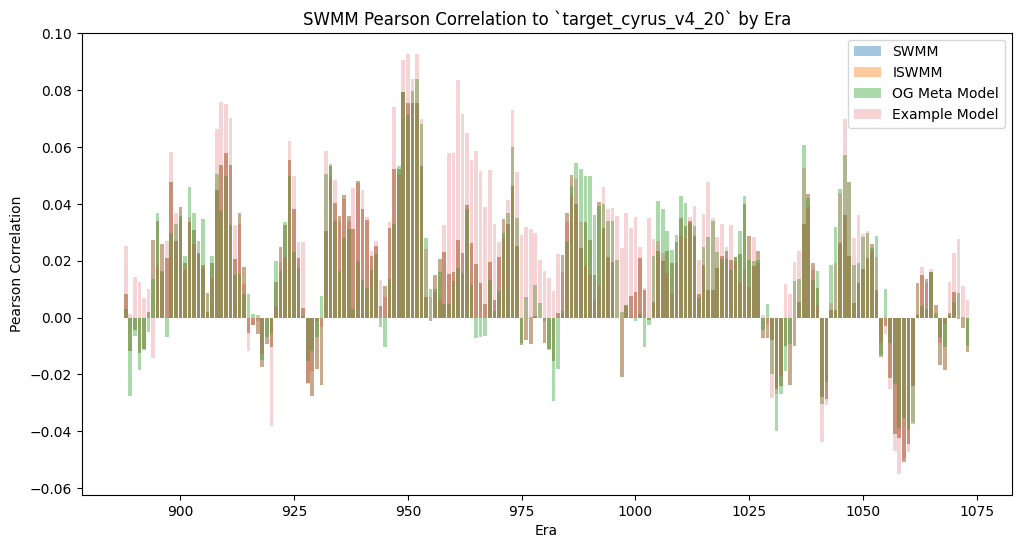

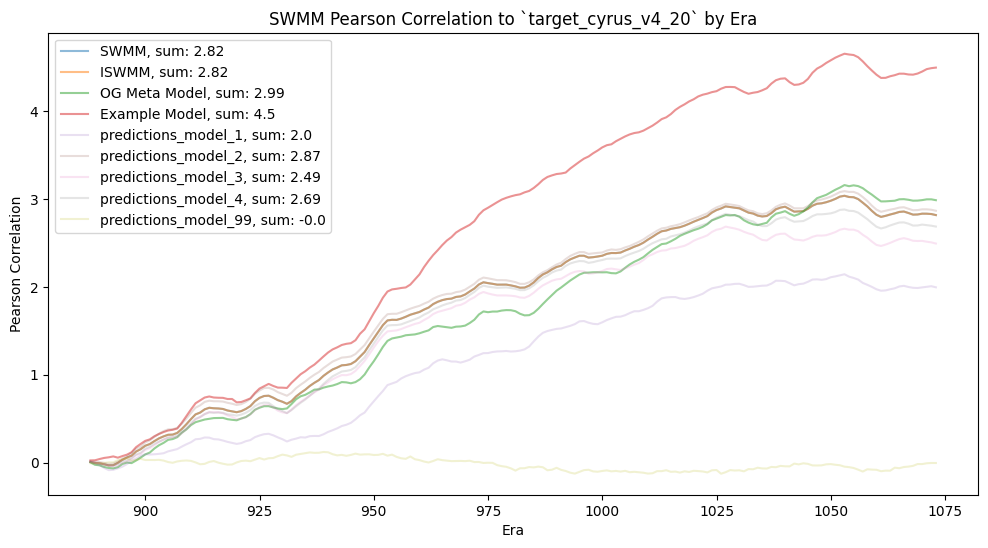

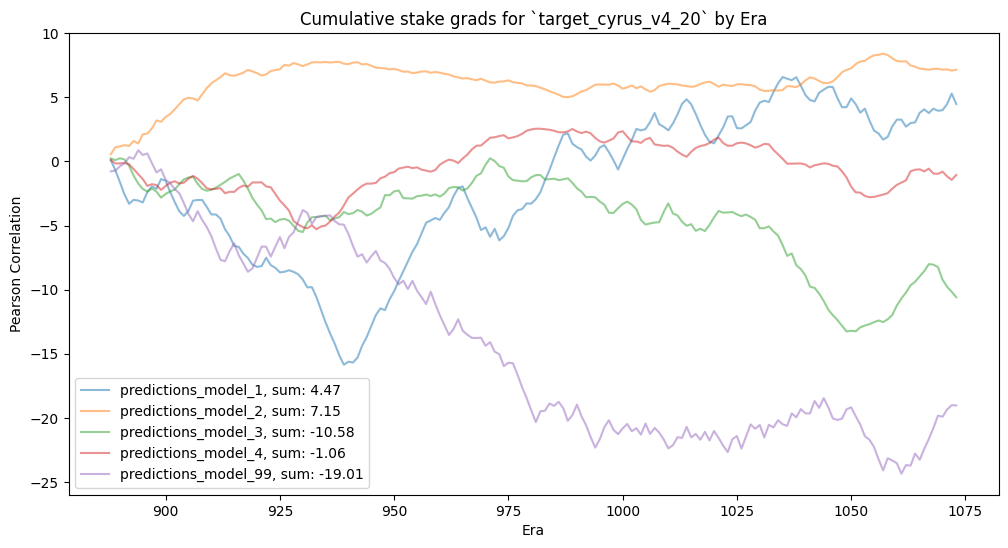

In [47]:
# plot correlations
plt.figure(figsize=(12, 6))
plt.bar(metrics["era"], metrics["swmm_corr"], label="SWMM", alpha=0.4)
plt.bar(metrics["era"], metrics["iswmm_corr"], label="ISWMM", alpha=0.4)
plt.bar(metrics["era"], metrics["og_mm_corr"], label="OG Meta Model", alpha=0.4)
plt.bar(metrics["era"], metrics["example_model_corr"], label="Example Model", alpha=0.2)
plt.title(f"SWMM Pearson Correlation to `{PRIMARY_TARGET}` by Era")
plt.legend()
plt.xlabel("Era")
plt.ylabel("Pearson Correlation")
plt.show()


# print cumulative plot of correlations
plt.figure(figsize=(12, 6))
plt.plot(metrics["era"], metrics["swmm_corr"].cumsum(), label=f"SWMM, sum: {metrics['swmm_corr'].sum().round(2)}", alpha=0.5)
plt.plot(metrics["era"], metrics["iswmm_corr"].cumsum(), label=f"ISWMM, sum: {metrics['iswmm_corr'].sum().round(2)}", alpha=0.5)
plt.plot(metrics["era"], metrics["og_mm_corr"].cumsum(), label=f"OG Meta Model, sum: {metrics['og_mm_corr'].sum().round(2)}", alpha=0.5)
plt.plot(metrics["era"], metrics["example_model_corr"].cumsum(), label=f"Example Model, sum: {metrics['example_model_corr'].sum().round(2)}", alpha=0.5)

# plot all models
for _col in model_performance.columns:
    if _col == "era":
        continue
    plt.plot(
        model_performance["era"],
        model_performance[_col].cumsum(),
        label=f"{_col}, sum: {model_performance[_col].sum().round(2)}",
        alpha=0.2,
    )

plt.title(f"SWMM Pearson Correlation to `{PRIMARY_TARGET}` by Era")
plt.legend()
plt.xlabel("Era")
plt.ylabel("Pearson Correlation")
plt.show()


# plot model stake_grads: cumulative
plt.figure(figsize=(12, 6))
for _col in model_stake_grads.columns:
    if _col == "era":
        continue
    plt.plot(
        model_stake_grads["era"],
        model_stake_grads[_col].cumsum(),
        label=f"{_col}, sum: {model_stake_grads[_col].sum().round(2)}",
        alpha=0.5,
    )

plt.title(f"Cumulative stake grads for `{PRIMARY_TARGET}` by Era")
plt.legend()
plt.xlabel("Era")
plt.ylabel("Pearson Correlation")
plt.show()


In [48]:
# s1T C(p1) + s2T C(p2) = (s1 + s2)T C( s1p1 + s2p)) 

In [49]:
(random_stake * _stake_grad).sum()

tensor(44.8736, grad_fn=<SumBackward0>)

This means we are far from the target and the OG meta model is better; way better! 

How do we calibrate local meta model to the OG meta model?

